In [46]:
import pandas as pd
import numpy as np
import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import lars_path, LinearRegression, Lasso, LassoCV
from sklearn.metrics import r2_score, mean_squared_error
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import requests, io, re

from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import ElasticNet

In [47]:
data_oct = pd.read_csv('/Users/jacopobinati/Desktop/HM2/listings_OCT_FINAL.csv')
data_oct.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,neighbourhood_group_cleansed,...,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,ln_price,property_House,property_Private room,property_Shared Room
0,NaN,NaN,f,1.0,2.0,"['email', 'phone']",t,f,Bushwick,Brooklyn,...,5.00,1,0,1,0,0.06,4.174387,False,True,False
1,NaN,NaN,f,1.0,1.0,"['email', 'phone']",t,t,Hell's Kitchen,Manhattan,...,NaN,1,0,1,0,NaN,4.700480,False,True,False
2,NaN,NaN,f,1.0,1.0,"['email', 'phone']",t,f,Sunnyside,Queens,...,NaN,1,1,0,0,NaN,4.595120,True,False,False
3,NaN,NaN,f,1.0,2.0,"['email', 'phone', 'work_email']",t,t,Bedford-Stuyvesant,Brooklyn,...,5.00,1,1,0,0,0.03,4.248495,True,False,False
4,NaN,100%,t,1.0,1.0,"['email', 'phone']",t,t,Bedford-Stuyvesant,Brooklyn,...,4.92,1,1,0,0,1.26,5.135798,True,False,False


In [48]:
columns_to_drop = ['host_verifications', 'latitude', 'longitude', 'neighbourhood_group_cleansed', 'host_listings_count',
                   'host_total_listings_count', 'maximum_nights_avg_ntm', 'minimum_minimum_nights', 'calendar_last_scraped',
                   'first_review']

data_oct.drop(columns_to_drop, axis=1, inplace=True)

In [49]:
for binary in [
    "host_is_superhost",
    "host_has_profile_pic",
    "host_identity_verified",
    "has_availability",
]:
    data_oct[binary] = data_oct[binary].map({"t": True, "f": False})

data_oct["f_property_type"] = data_oct["property_type"].astype("category")
data_oct["f_neighbourhood_cleansed"] = data_oct["neighbourhood_cleansed"].astype("category")
data_oct['n_bathroom'] = data_oct['bathrooms_text'].str.extract('(\d+\.?\d*)').astype(float)

In [50]:
numericals = [
    "accommodates",
    "review_scores_value",
    "number_of_reviews_ltm",
    "number_of_reviews_l30d",
    "review_scores_location",
    "review_scores_communication",
    "review_scores_checkin",
    "review_scores_cleanliness",
    "reviews_per_month",
    "minimum_nights",
    "beds"
]

for col in numericals:
    data_oct["n_" + col] = pd.to_numeric(data_oct[col], errors="coerce")

In [51]:
data_oct.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,beds,...,n_review_scores_value,n_number_of_reviews_ltm,n_number_of_reviews_l30d,n_review_scores_location,n_review_scores_communication,n_review_scores_checkin,n_review_scores_cleanliness,n_reviews_per_month,n_minimum_nights,n_beds
0,NaN,NaN,False,True,False,Bushwick,Private room,1,1 shared bath,1.0,...,5.00,0,0,4.80,5.00,5.00,5.00,0.06,30,1.0
1,NaN,NaN,False,True,True,Hell's Kitchen,Private room,2,1 bath,1.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,30,1.0
2,NaN,NaN,False,True,False,Sunnyside,House,1,1 bath,1.0,...,NaN,0,0,NaN,NaN,NaN,NaN,NaN,30,1.0
3,NaN,NaN,False,True,True,Bedford-Stuyvesant,House,2,1 bath,1.0,...,5.00,0,0,5.00,5.00,5.00,5.00,0.03,45,1.0
4,NaN,100%,True,True,True,Bedford-Stuyvesant,House,4,1 bath,2.0,...,4.92,14,0,4.94,4.91,4.95,4.99,1.26,30,2.0


In [52]:
data_oct["n_review_scores_value"].fillna(data_oct["n_review_scores_value"].mean(), inplace=True)
data_oct["n_review_scores_location"].fillna(data_oct["n_review_scores_location"].mean(), inplace=True)
data_oct["n_review_scores_communication"].fillna(data_oct["n_review_scores_communication"].mean(), inplace=True)
data_oct["n_review_scores_checkin"].fillna(data_oct["n_review_scores_checkin"].mean(), inplace=True)
data_oct["n_reviews_per_month"].fillna(data_oct["n_reviews_per_month"].mean(), inplace=True)

data_oct = data_oct.assign(
    flag_review_scores_value=np.multiply(data_oct.n_review_scores_value.isna(), 1),
    n_review_scores_rating=data_oct.n_review_scores_value.fillna(
        np.mean(data_oct.n_review_scores_value.dropna())
    ),
    flag_review_scores_location=np.multiply(data_oct.n_review_scores_location.isna(), 1),
    n_review_scores_location=data_oct.n_review_scores_location.fillna(
        np.mean(data_oct.n_review_scores_location.dropna())
    ),

    flag_review_scores_communication=np.multiply(data_oct.n_review_scores_communication.isna(), 1),
    n_review_scores_communication=data_oct.n_review_scores_communication.fillna(
        np.mean(data_oct.n_review_scores_communication.dropna())
    ),

    flag_review_scores_checkin=np.multiply(data_oct.n_review_scores_checkin.isna(), 1),
    n_review_scores_checkin=data_oct.n_review_scores_checkin.fillna(
        np.mean(data_oct.n_review_scores_checkin.dropna())
    ),

    flag_reviews_per_month=np.multiply(data_oct.n_reviews_per_month.isna(), 1),
    n_reviews_per_month=data_oct.n_reviews_per_month.fillna(
        np.mean(data_oct.n_reviews_per_month.dropna())
    ),

    flag_review_scores_cleanliness=np.multiply(data_oct.n_review_scores_cleanliness.isna(), 1),
    n_review_scores_cleanliness=data_oct.n_review_scores_cleanliness.fillna(
        np.mean(data_oct.n_review_scores_cleanliness.dropna())
    ),
)

In [53]:
variable_names = data_oct.columns.tolist()
variable_table = pd.DataFrame(variable_names, columns=["Variable Names"])
pd.set_option('display.max_rows', None)
print(variable_table)

                                  Variable Names
0                             host_response_rate
1                           host_acceptance_rate
2                              host_is_superhost
3                           host_has_profile_pic
4                         host_identity_verified
5                         neighbourhood_cleansed
6                                  property_type
7                                   accommodates
8                                 bathrooms_text
9                                           beds
10                                     amenities
11                                         price
12                                minimum_nights
13                                maximum_nights
14                              has_availability
15                               availability_30
16                               availability_60
17                               availability_90
18                              availability_365
19                  

In [54]:
replace_str_dict = {
    '"' : "",
    ", " : ",",
    "\\\\" : "",
    ":" : "",
    "\\+" : "_",
}

data_oct["amenities"] = data_oct["amenities"].replace(replace_str_dict, regex=True).str.strip("[]").str.split(",")

In [55]:
def merge_items_with_keywords(amenities_list, merge_dict):
    merged_amenities = []
    for amenities in amenities_list:
        merged_item = []
        for amenity in amenities:
            lower_amenity = amenity.lower()
            for new_category, old_categories in merge_dict.items():
                if any(old_category in lower_amenity for old_category in old_categories):
                    merged_item.append(new_category)
                    break
            else:
                merged_item.append(amenity)
        merged_amenities.append(list(set(merged_item)))
    return merged_amenities

In [56]:

merge_dict = {
    'wifi': ['wifi'],
    'kitchen': ['kitchen', 'kitchenette'],
    'stove': ['stove'],
    'oven': ['oven'],
    'microwave': ['microwave'],
    'refrigerator': ['refrigerator', 'fridge'],
    'dishwasher': ['dishwasher'],
    'kettel': ['kettle'],
    'toaster': ['toaster'],
    'coffee': ['coffee maker', 'machine', 'coffee', 'espresso', 'nespresso'],
    'tv': ['tv'],
    'sound_system': ['speaker', 'sound'],
    'game_console': ['game console', 'ps2', 'ps3', 'ps4', 'ps5', 
                     'playstation', 'wii', 'xbox'],
    'baby': ['baby', 'toys'],
    'body_wash': ['body', 'soap', 'shower gel'],
    'shampoo': ['shampoo'],
    'conditioner': ['conditioner'],
    'hair dryer': ['hair dryer'],
    'laundry': ['washer', 'laundry'],
    'backyard': ['backyard'],
    'grill': ['grill'],
    'breakfast': ['breakfast'],
    'clothing_storage': ['clothing storage'],
    'ac': ['ac - split type ductless system', 'air conditioning', 'central air conditioning', 'window ac unit'],
    'heating': ['heating']
}
data_oct['amenities'] = merge_items_with_keywords(data_oct['amenities'], merge_dict)
dummies = data_oct['amenities'].str.join('|').str.get_dummies()
dummies.columns = "d_" + dummies.columns.str.replace('/', '_').str.replace(' ', '_').str.replace('-', '_').str.replace('\\\\', '')

In [57]:
dummies.head()

,d_*Also,d_000_BTU_in_the_Bedroom_and_12,d_100%_Vegan,d_2_5_years_old,d_24_hour_fitness_center,d_26.4_QT_25_L,d_5_10_years_old,d_9,d_AVON,d_Aesop,...,d_stationary_bike,d_stove,d_tesla_only,d_toaster,d_treadmill,d_tv,d_wardrobe,d_wifi,d_wood_burning,d_yoga_mat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,1,0,1,0,0


In [58]:
top_150_columns = dummies.sum().sort_values(ascending=False).head(150).index
final_dummies = dummies[top_150_columns]
final_dummies.head()

,d_wifi,d_Smoke_alarm,d_kitchen,d_heating,d_ac,d_Essentials,d_tv,d_Carbon_monoxide_alarm,d_Hangers,d_Hot_water,...,d_Paid_parking_lot_off_premises,d_Private_hot_tub,d_Fireplace_guards,d_Resort_access,d_EV_charger,d_Changing_table,d_Beach_access,d_stationary_bike,d_Exercise_equipment_yoga_mat,d_Bay_view
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [59]:
data_oct = pd.concat([data_oct, final_dummies], axis=1)
data_oct.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,property_type,accommodates,bathrooms_text,beds,...,d_Paid_parking_lot_off_premises,d_Private_hot_tub,d_Fireplace_guards,d_Resort_access,d_EV_charger,d_Changing_table,d_Beach_access,d_stationary_bike,d_Exercise_equipment_yoga_mat,d_Bay_view
0,NaN,NaN,False,True,False,Bushwick,Private room,1,1 shared bath,1.0,...,0,0,0,0,0,0,0,0,0,0
1,NaN,NaN,False,True,True,Hell's Kitchen,Private room,2,1 bath,1.0,...,0,0,0,0,0,0,0,0,0,0
2,NaN,NaN,False,True,False,Sunnyside,House,1,1 bath,1.0,...,0,0,0,0,0,0,0,0,0,0
3,NaN,NaN,False,True,True,Bedford-Stuyvesant,House,2,1 bath,1.0,...,0,0,0,0,0,0,0,0,0,0
4,NaN,100%,True,True,True,Bedford-Stuyvesant,House,4,1 bath,2.0,...,0,0,0,0,0,0,0,0,0,0


In [60]:
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_bathroom",
    "n_beds",
    "f_property_type",
    "f_neighbourhood_cleansed"
]

# reviews
reviews = [
    "n_review_scores_value",
    "flag_review_scores_value",
    "n_review_scores_location",
    "flag_review_scores_location",
    "n_review_scores_communication",
    "flag_review_scores_communication",
    "n_review_scores_checkin",
    "flag_review_scores_checkin",
    "n_review_scores_cleanliness",
    "flag_review_scores_cleanliness",
    "n_reviews_per_month",
    "flag_reviews_per_month"
]

# Dummy variables
amenities = [col for col in data_oct if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "d_breakfast:f_property_type",
    "d_heating:n_accommodates",
    "d_ac:f_property_type",
]
# with neighbourhood
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
    "d_wifi:f_neighbourhood_cleansed",
    "d_Smoke_alarm:f_neighbourhood_cleansed",
]

In [61]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_3 = basic_vars + reviews + amenities + X1 + X2

In [62]:
data_oct.to_csv('/Users/jacopobinati/Desktop/HM2/listings_OCT_FINAL2.csv', index=False)

In [63]:
data_train, data_holdout = train_test_split(data_oct, train_size=0.8, random_state=42)

# Random Forest

In [87]:
ncores = 5

In [88]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=500,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {"max_features": [4, 6, 8], "min_samples_split": [6, 11]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=3
)

y, X = dmatrices("price ~ " + " + ".join(predictors_1), data_train)

rf_model_1 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=4, min_samples_split=6;, score=-305.945 total time=  58.5s
[CV 2/5] END max_features=4, min_samples_split=6;, score=-343.178 total time=  38.4s
[CV 3/5] END max_features=4, min_samples_split=6;, score=-352.189 total time=  32.5s
[CV 4/5] END max_features=4, min_samples_split=6;, score=-275.536 total time=  45.3s
[CV 5/5] END max_features=4, min_samples_split=6;, score=-306.782 total time=  50.4s
[CV 1/5] END max_features=4, min_samples_split=11;, score=-303.368 total time=  38.1s
[CV 2/5] END max_features=4, min_samples_split=11;, score=-344.525 total time=  40.0s
[CV 3/5] END max_features=4, min_samples_split=11;, score=-350.977 total time=  42.1s
[CV 4/5] END max_features=4, min_samples_split=11;, score=-275.103 total time=  34.6s
[CV 5/5] END max_features=4, min_samples_split=11;, score=-306.110 total time=  35.6s
[CV 1/5] END max_features=6, min_samples_split=6;, score=-305.958 total time=  37.6s


In [89]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=500,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {
    "max_features": [10, 12, 14],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

rf_model_2 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=10, min_samples_split=6;, score=-290.532 total time=  44.1s
[CV 2/5] END max_features=10, min_samples_split=6;, score=-337.863 total time=  43.7s
[CV 3/5] END max_features=10, min_samples_split=6;, score=-345.543 total time=  37.7s
[CV 4/5] END max_features=10, min_samples_split=6;, score=-262.787 total time=  30.8s
[CV 5/5] END max_features=10, min_samples_split=6;, score=-297.703 total time=  30.7s
[CV 1/5] END max_features=10, min_samples_split=11;, score=-293.477 total time=  29.1s
[CV 2/5] END max_features=10, min_samples_split=11;, score=-341.086 total time=  28.3s
[CV 3/5] END max_features=10, min_samples_split=11;, score=-347.570 total time=  28.1s
[CV 4/5] END max_features=10, min_samples_split=11;, score=-266.322 total time=  35.6s
[CV 5/5] END max_features=10, min_samples_split=11;, score=-301.877 total time=  30.4s
[CV 1/5] END max_features=10, min_samples_split=16;, score=-295.794 total t

In [90]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=500,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {
    "max_features": [10, 12, 14],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)

rf_model_3 = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=10, min_samples_split=6;, score=-292.998 total time= 1.2min
[CV 2/5] END max_features=10, min_samples_split=6;, score=-340.401 total time= 1.4min
[CV 3/5] END max_features=10, min_samples_split=6;, score=-348.720 total time= 1.2min
[CV 4/5] END max_features=10, min_samples_split=6;, score=-266.878 total time= 1.4min
[CV 5/5] END max_features=10, min_samples_split=6;, score=-299.698 total time= 1.2min
[CV 1/5] END max_features=10, min_samples_split=11;, score=-295.909 total time= 1.2min
[CV 2/5] END max_features=10, min_samples_split=11;, score=-344.388 total time= 1.3min
[CV 3/5] END max_features=10, min_samples_split=11;, score=-350.671 total time= 1.1min
[CV 4/5] END max_features=10, min_samples_split=11;, score=-269.654 total time= 1.3min
[CV 5/5] END max_features=10, min_samples_split=11;, score=-303.372 total time= 1.1min
[CV 1/5] END max_features=10, min_samples_split=16;, score=-297.884 total t

In [91]:
pd.DataFrame(rf_model_1.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,4,6,8
Min_nodes,,,
5,316.73,316.49,316.47
10,316.02,315.89,315.79


In [92]:
pd.DataFrame(rf_model_2.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,10,12,14
Min_nodes,,,
5,306.89,305.90,305.03
10,310.07,308.97,307.54
15,312.18,311.15,309.99


In [93]:
pd.DataFrame(rf_model_3.cv_results_)[
    ["param_max_features", "param_min_samples_split", "mean_test_score"]
].assign(
    mean_test_score=lambda x: x["mean_test_score"] * -1,
    Variables=lambda x: x["param_max_features"],
    Min_nodes=lambda x: x["param_min_samples_split"] - 1,
).pivot(
    index="Min_nodes", columns="Variables", values="mean_test_score"
).round(
    2
)

Variables,10,12,14
Min_nodes,,,
5,309.74,309.37,308.68
10,312.80,312.24,311.55
15,314.54,314.28,313.61


In [94]:
pd.DataFrame(
    {
        "Min vars": [
            rf_model_1.best_estimator_.max_features,
            rf_model_2.best_estimator_.max_features,
            rf_model_3.best_estimator_.max_features,
        ],
        "Min nodes": [
            rf_model_1.best_estimator_.min_samples_split - 1,
            rf_model_2.best_estimator_.min_samples_split - 1,
            rf_model_3.best_estimator_.min_samples_split - 1,
        ],
    },
    ["Model A", "Model B", "Model C"],
)

,Min vars,Min nodes
Model A,8,10
Model B,14,5
Model C,14,5


In [95]:
pd.DataFrame(
    {
        "RMSE": [
            rf_model_1.cv_results_["mean_test_score"].min(),
            rf_model_2.cv_results_["mean_test_score"].min(),
            rf_model_3.cv_results_["mean_test_score"].min(),
        ]
    },
    ["Model A", "Model B", "Model C"],
).round(2) * -1

,RMSE
Model A,316.73
Model B,312.18
Model C,314.54


# OLS

In [73]:
mod1 = smf.ols("price ~ " + " + ".join(amenities), data=data_train)

In [74]:
y, X = dmatrices("price ~ " + " + ".join(predictors_1), data_train)
ols_model1 = LinearRegression().fit(X,y)
y_hat1 = ols_model1.predict(X)
ols_rmse1 = mean_squared_error(y,y_hat1,squared=False)

y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_1), data_holdout)
ols_test1 = LinearRegression().fit(X_test,y_test)
y_hat_test1 = ols_test1.predict(X_test)
ols_cv_rmse1 = mean_squared_error(y_test,y_hat_test1,squared=False)
#-----------------------------------#

y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)
ols_model2 = LinearRegression().fit(X,y)
y_hat2 = ols_model2.predict(X)
ols_rmse2 = mean_squared_error(y,y_hat2,squared=False)


y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)
ols_test2 = LinearRegression().fit(X_test,y_test)
y_hat_test2 = ols_test2.predict(X_test)
ols_cv_rmse2 = mean_squared_error(y_test,y_hat_test2,squared=False)
#-----------------------------------#

y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)
ols_model3 = LinearRegression().fit(X,y)
y_hat3 = ols_model3.predict(X)
ols_rmse3 = mean_squared_error(y,y_hat3,squared=False)

y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_3), data_holdout)
ols_test3 = LinearRegression().fit(X_test,y_test)
y_hat_test3 = ols_test3.predict(X_test)
ols_cv_rmse3 = mean_squared_error(y_test,y_hat_test3,squared=False)

# LASSO

In [75]:
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [76]:
lambdas = np.arange(0.05, 1.01, 0.05)
print(lambdas)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]


In [77]:
y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)
X_featnames = X.design_info.column_names
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [78]:
lasso_fit = LassoCV(alphas=lambdas, cv=5, random_state=42).fit(X, y)

/Users/jacopobinati/opt/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1561: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [79]:
lasso_fit.alpha_

1.0

In [80]:
rmse_lambda_folds = (
    pd.DataFrame(lasso_fit.mse_path_, index=lambdas[::-1])
    .apply(np.sqrt)
    .mean(axis=1)
    .to_frame(name="Test RMSE")
    .round(2)
)

In [81]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)

lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
    n_jobs=ncores,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_3), data_train)
y, X = np.array(y), np.array(X)

lasso_model_cv.fit(X, y.ravel())

lasso_rmse = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha]
    .mean_test_score.values[0]
    * -1
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 3/5] END .....................alpha=0.01;, score=-354.524 total time= 1.3min
[CV 1/5] END .....................alpha=0.01;, score=-308.958 total time= 1.4min
[CV 2/5] END .....................alpha=0.01;, score=-351.743 total time= 1.7min
[CV 1/5] END .....................alpha=0.02;, score=-308.437 total time=  36.4s
[CV 5/5] END .....................alpha=0.01;, score=-310.691 total time=  55.6s
[CV 4/5] END .....................alpha=0.01;, score=-276.143 total time= 1.0min
[CV 3/5] END .....................alpha=0.02;, score=-354.074 total time=  33.5s
[CV 2/5] END .....................alpha=0.02;, score=-351.142 total time=  49.8s
[CV 4/5] END .....................alpha=0.02;, score=-275.679 total time=  44.3s
[CV 5/5] END .....................alpha=0.02;, score=-309.983 total time=  36.5s
[CV 1/5] END .....................alpha=0.03;, score=-308.099 total time=  29.4s
[CV 2/5] END .....................alpha=0.03;, 

In [82]:
lasso_rmse

318.0990148353594

# Final Comparison for October

In [96]:
rmse_values = [ols_rmse1, ols_rmse2, ols_rmse3, np.nan, np.nan, np.nan]
cv_rmse_values = [ols_cv_rmse1, ols_cv_rmse2, ols_cv_rmse3, rmse_lambda_folds.loc[lasso_fit.alpha_].values[0], lasso_rmse, rf_model_3.cv_results_["mean_test_score"].min() * -1]
model_names = ['OLS 1', 'OLS 2', 'OLS 3', 'LASSO 1', 'LASSO 2', 'RF']


df = pd.DataFrame({'Model': model_names, 'Train RMSE': rmse_values, 'Test RMSE': cv_rmse_values})

df['Train RMSE'] = df['Train RMSE'].round(2)
df['Test RMSE'] = df['Test RMSE'].round(2)

print(df)



     Model  Train RMSE  Test RMSE
0    OLS 1      330.13     329.26
1    OLS 2      323.05     320.40
2    OLS 3      310.38     276.13
3  LASSO 1         NaN     319.27
4  LASSO 2         NaN     318.10
5       RF         NaN     314.54


### Variable importance Random Forest, model 3

In [98]:
rf_model_3_var_imp_df = (
    pd.DataFrame(
        rf_model_3.best_estimator_.feature_importances_, X.design_info.column_names
    )
    .reset_index()
    .rename({"index": "varname", 0: "imp"}, axis=1)
    .assign(
        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
        varname=lambda x: x.varname.str.replace(
            "f_room_type[T.", "Room type:", regex=False
        )
        .str.replace("f_neighbourhood_cleansed[T.", "Borough:", regex=False)
        .str.replace("]", "", regex=False),
    )
    .sort_values(by=["imp"], ascending=False)
)

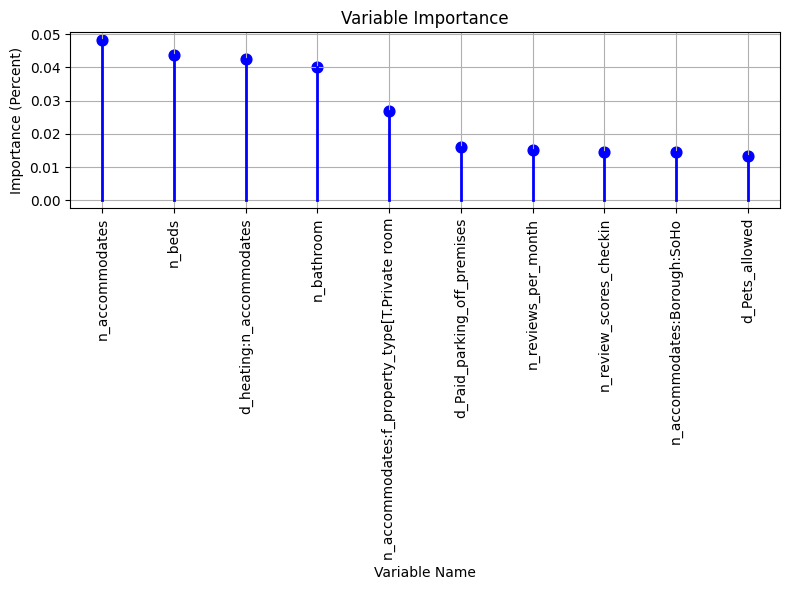

In [104]:
subset_df = rf_model_3_var_imp_df.iloc[:10, :]
color = ['blue']
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(subset_df['varname'], subset_df['imp_percentage'], color=color[0], s=60, label='Variable Importance')
for index, row in subset_df.iterrows():
    ax.plot([row['varname'], row['varname']], [0, row['imp_percentage']], color=color[0], linewidth=2)

ax.set_ylabel('Importance (Percent)')
ax.set_xlabel('Variable Name')
ax.set_title('Variable Importance')
plt.xticks(rotation=90)
ax.grid(True)
plt.tight_layout()
plt.show()